In [2]:
# Downloading the dataset!

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

/home/eypsrcnuygr/.local/lib/python3.8/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [104]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [8]:
X, y = mnist.data, mnist.target

X.shape

784

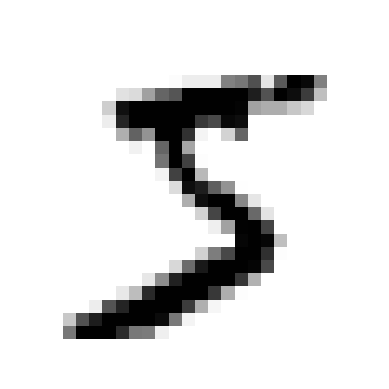

In [9]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [10]:
y[0]

'5'

In [11]:
# The data is already splited so we just assign them to variables
# Also the traning set is already shuffled!

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [16]:
# This takes the non-5s into consideration

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [17]:
# The accuracy is just the probability that 5 is not the guess which makes sense.
# The data is divided equally probably!

cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [24]:
# Top left is the true negative, bottom right is the true positive
# the others are the false predictions

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [25]:
# precision score is the percentage for truthness
# recall is the truthness sensivity, so only the fraction that it gives are detected!

from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))

print(recall_score(y_train_5, y_train_pred))


0.8370879772350012
0.6511713705958311


In [26]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [28]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

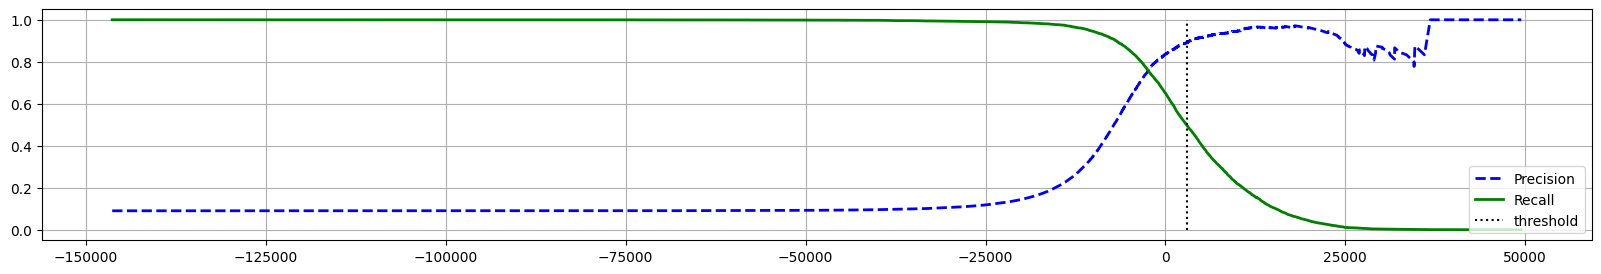

In [56]:
threshold = 3000
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.rcParams["figure.figsize"] = (20,3)
plt.legend(loc="lower right")
plt.grid()
plt.show()

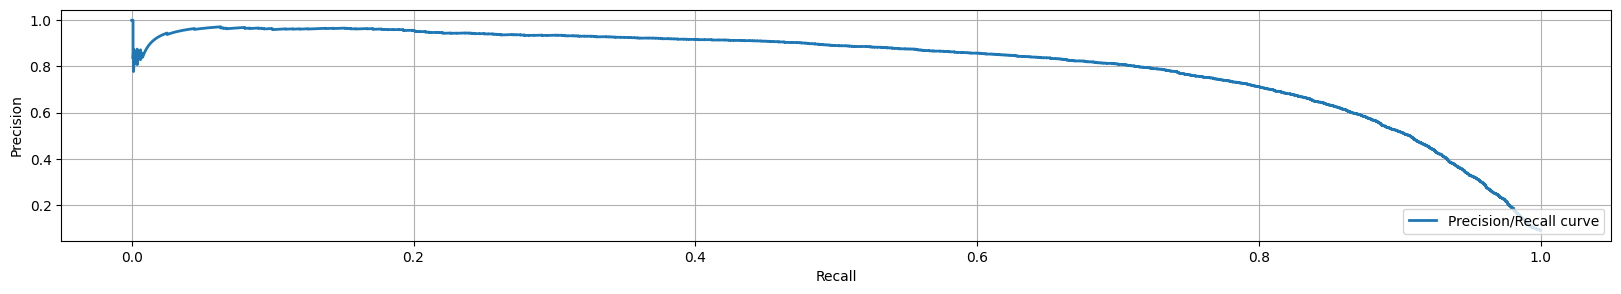

In [75]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [66]:
# we choose 90 percent precision and for that precision we are trying to find the threshold!

idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [67]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [68]:
print(precision_score(y_train_5, y_train_pred_90))

recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)

recall_at_90_precision

0.9000345901072293


0.4799852425751706

In [69]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

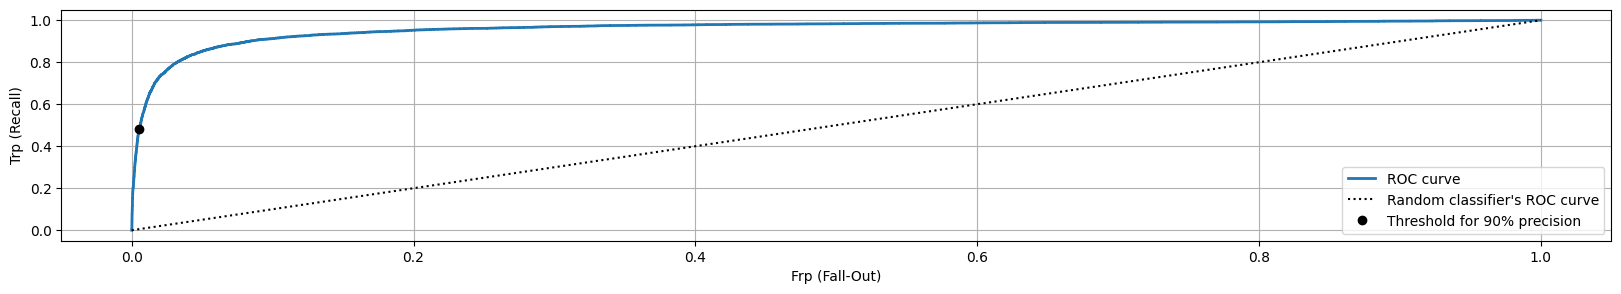

In [76]:
# thresholds are listed in decreasing order!
# If threshold increases TRP decreases!

idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.legend()
plt.grid()
plt.ylabel('Trp (Recall)')
plt.xlabel('Frp (Fall-Out)')
plt.show()

In [77]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [78]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [79]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [80]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [81]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

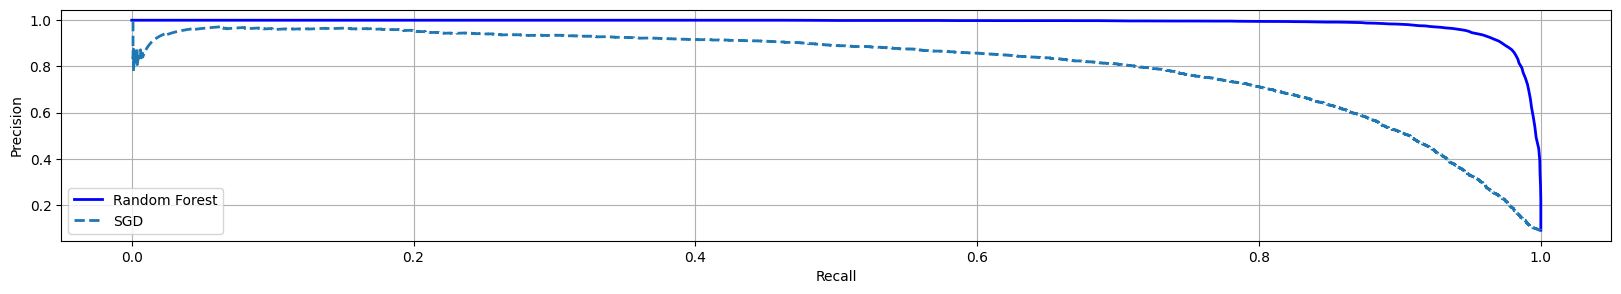

In [82]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.legend()
plt.grid()
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [83]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5

print(f1_score(y_train_5, y_train_pred_forest))

print(roc_auc_score(y_train_5, y_scores_forest))

0.9274509803921569
0.9983436731328145


In [84]:
print(precision_score(y_train_5, y_train_pred_forest))
print(recall_score(y_train_5, y_train_pred_forest))

0.9897468089558485
0.8725327430363402


Multi Class Classification

In [89]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) # not y_train_5

SVC(random_state=42)

In [90]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [91]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [92]:
class_id = some_digit_scores.argmax()
class_id

5

In [93]:
print(svm_clf.classes_)

print(svm_clf.classes_[class_id])

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
5


Changing the Strategy to OVR (One versus Rest)

In [94]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [95]:
print(ovr_clf.predict([some_digit]))

len(ovr_clf.estimators_)

['5']


10

Error Analysis

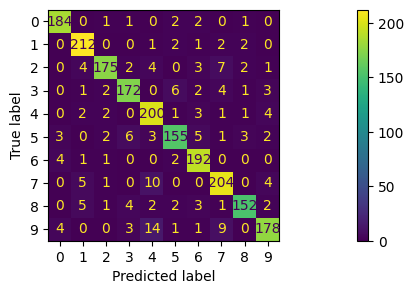

In [97]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(ovr_clf, X_train[:2000], y_train[:2000], cv=3)
ConfusionMatrixDisplay.from_predictions(y_train[:2000], y_train_pred)
plt.show()

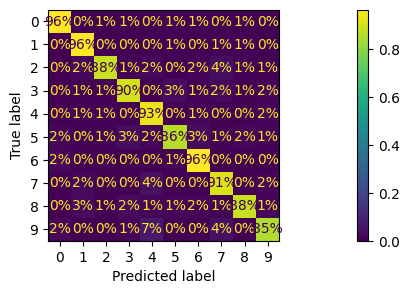

In [99]:
ConfusionMatrixDisplay.from_predictions(y_train[:2000], y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

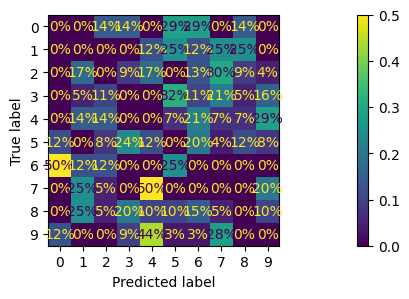

In [101]:
# We've excluded the correct predictions! It's normalized by row!

sample_weight = (y_train_pred != y_train[:2000])
ConfusionMatrixDisplay.from_predictions(y_train[:2000], y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

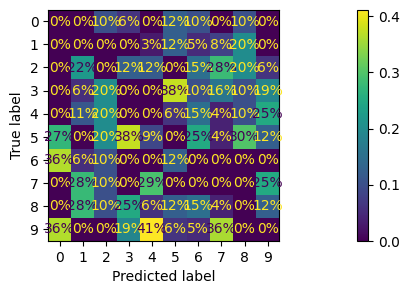

In [102]:
# It's normalized by column!

sample_weight = (y_train_pred != y_train[:2000])
ConfusionMatrixDisplay.from_predictions(y_train[:2000], y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
plt.show()

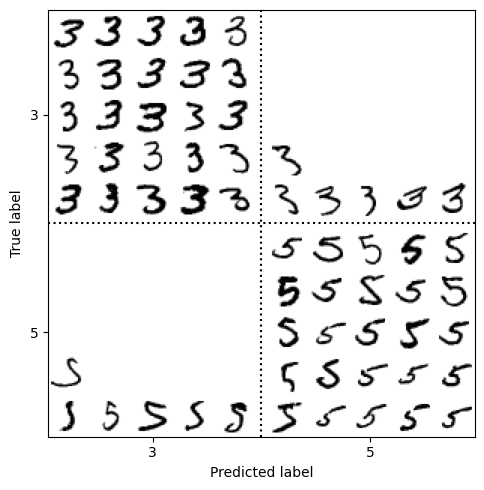

In [105]:
cl_a, cl_b = '3', '5'
X_aa = X_train[:2000][(y_train[:2000] == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[:2000][(y_train[:2000] == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[:2000][(y_train[:2000] == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[:2000][(y_train[:2000] == cl_b) & (y_train_pred == cl_b)]

size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
save_fig("error_analysis_digits_plot")
plt.show()

Multi Output

In [112]:
import numpy as np

np.random.seed(42)  # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

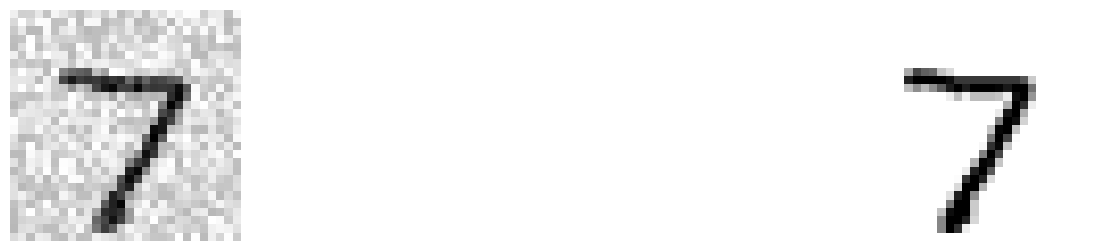

In [113]:
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])

plt.show()

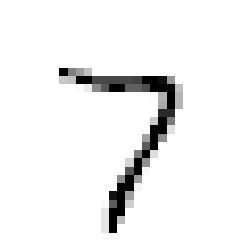

In [114]:
from sklearn.neighbors import KNeighborsClassifier 

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()